In [1]:
import torch
import yaml
import os
from models.rbm import RBM
from models.crbm import CRBM
from utils.data_loader import load_image_data, load_tabular_data
from train import train_rbm
from generate import generate_samples
from utils.augmentation import augment_dataset
from utils.evaluation import evaluate_classifier, ks_test_distribution
from utils.visualization import visualize_tsne
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [3]:
with open("configs/config.yaml") as f:
    cfg = yaml.safe_load(f)


In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
if cfg['dataset_type'] == 'image':
    loader, dataset = load_image_data(cfg['batch_size'])
    n_visible = 28 * 28  # For MNIST images (flattened)
else:
    loader, features, labels = load_tabular_data(cfg['dataset_name'], cfg['batch_size'])
    n_visible = features.shape[1]

In [6]:
if cfg['rbm_type'] == "RBM":
    model = RBM(n_visible, cfg['hidden_units']).to(device)
else:
    n_classes = 10 if cfg['dataset_type'] == 'image' else len(set(labels))
    model = CRBM(n_visible, cfg['hidden_units'], n_classes).to(device)


In [7]:
train_rbm(model, loader, cfg['epochs'], cfg['learning_rate'], k=cfg.get('gibbs_steps', 1), device=device, is_crbm=(cfg['rbm_type'] == 'CRBM'))

Epoch 1/5 | Loss: -22877.1103
Epoch 2/5 | Loss: -28488.0971
Epoch 3/5 | Loss: -33881.5719
Epoch 4/5 | Loss: -39277.3599
Epoch 5/5 | Loss: -44675.1136


In [8]:
if cfg['rbm_type'] == 'CRBM':
    conditions = torch.eye(n_classes).to(device)  # One-hot encoding for classes
    samples = generate_samples(model, cfg['augmentation_size'], n_visible, device, conditions)
    synth_labels = torch.arange(conditions.shape[0]).repeat(cfg['augmentation_size'] // conditions.shape[0]).to(device)
else:
    samples = generate_samples(model, cfg['augmentation_size'], n_visible, device)
    synth_labels = torch.randint(0, 10, (cfg['augmentation_size'],)).to(device)  # Fallback for labels

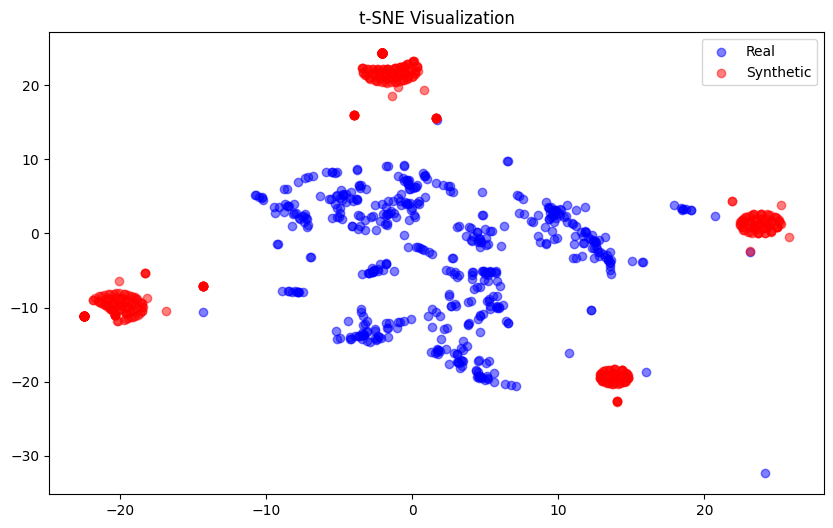

In [9]:
if cfg.get('visualize', False):
    visualize_tsne(dataset.data.view(-1, n_visible).float()[:500], samples[:500])

In [10]:
print("Training classifier on augmented data...")
real_data = dataset.data.view(-1, n_visible).float() / 255.0  # Normalize image data
real_labels = dataset.targets.to(device)

aug_data, aug_labels = augment_dataset(real_data, samples, real_labels, synth_labels)

accuracy = evaluate_classifier(
    aug_data.cpu().numpy(), 
    aug_labels.cpu().numpy(), 
    real_data.cpu().numpy(), 
    real_labels.cpu().numpy()
)
print(f"Classifier accuracy with augmentation: {accuracy}")

Training classifier on augmented data...
Classifier accuracy with augmentation: 0.9386166666666667
